In [1]:
import os
from datetime import datetime, timedelta
import pandas as pd
import quandl as qd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

In [2]:
key = os.environ.get('Quandl_API_Key')
qd.ApiConfig.api_key = key

In [3]:
# "RATEINF/INFLATION_USA" "MULTPL/SP500_PE_RATIO_MONTH" "MULTPL/SP500_EARNINGS_MONTH"

In [4]:
today = datetime.today().date()

# get the actual day number
today_day_num = today.strftime("%d")

In [5]:
start_date = "1963-01-01"

end_date = today - timedelta(days=int(today_day_num) - 1) #Establish the end date as the first date of the current month

inflation_data = qd.get("RATEINF/INFLATION_USA", start_date = start_date, end_date = end_date)

pe_data = qd.get("MULTPL/SP500_PE_RATIO_MONTH", start_date = start_date, end_date = end_date)

In [6]:
df = pd.merge_asof(left=inflation_data, right=pe_data, right_index=True,left_index=True,direction='nearest') #Merge to the closest date since the days do not line up perfectly
df = df.rename(columns={'Value_x':'Inflation',
                        'Value_y':'S&P500_PE'})
df

,Inflation,S&P500_PE
Date,,
1963-01-31,1.333,17.83
1963-02-28,0.997,17.70
1963-03-31,1.329,18.32
1963-04-30,0.993,18.47
1963-05-31,0.993,18.26
...,...,...
2022-08-31,8.263,19.98
2022-09-30,8.202,18.12
2022-10-31,7.745,20.14


In [7]:
df.describe()

,Inflation,S&P500_PE
count,720.000000,720.000000
mean,3.893001,19.619361
std,2.861944,11.844516
min,-2.097000,6.790000
25%,1.977000,14.297500
50%,3.087500,18.040000
75%,4.869250,22.432500
max,14.756000,123.730000


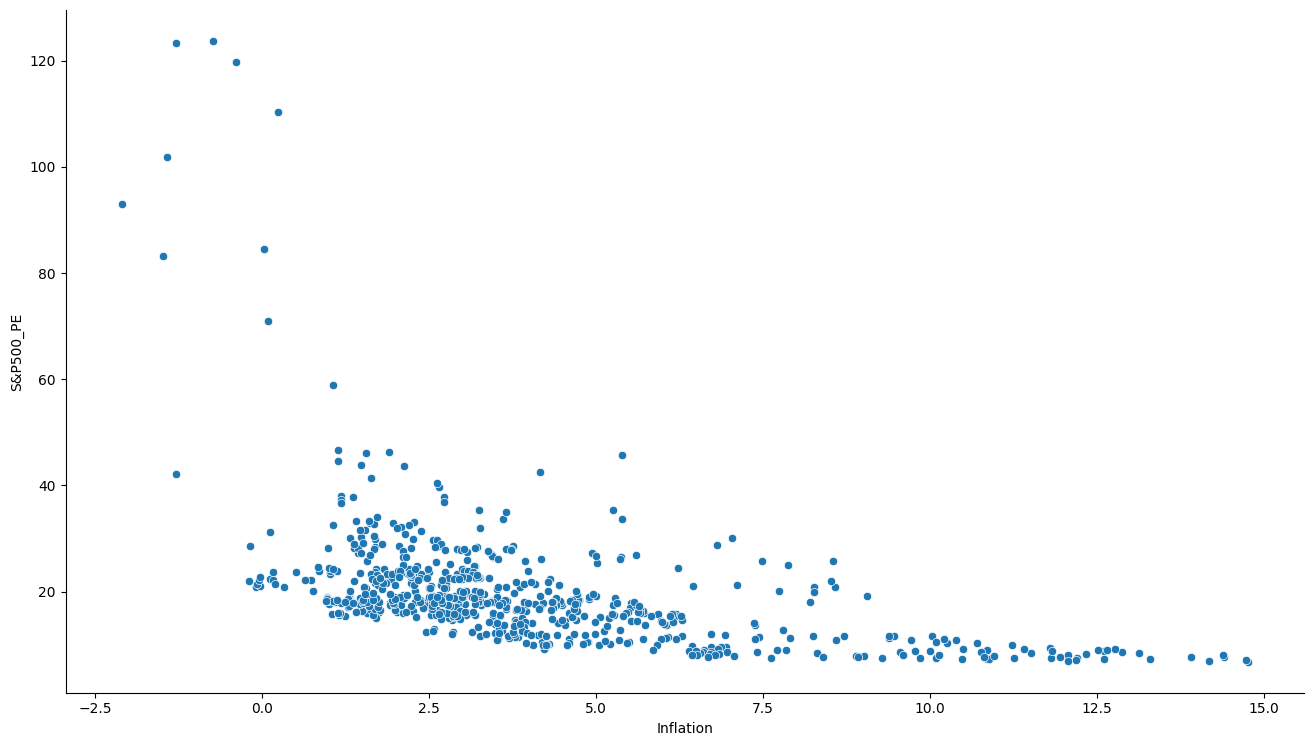

In [8]:
g = sns.relplot(x='Inflation', y='S&P500_PE', data=df)
g.fig.set_size_inches(15,8)

In [10]:
#Remove outliers in S&P 500

#upper_limit = df['S&P500_PE'].mean()+2*df['S&P500_PE'].std()
#lower_limit = df['S&P500_PE'].mean()-2*df['S&P500_PE'].std()

upper_limit = df['S&P500_PE'].quantile(0.95)

df = df[(df['S&P500_PE'] < upper_limit)]

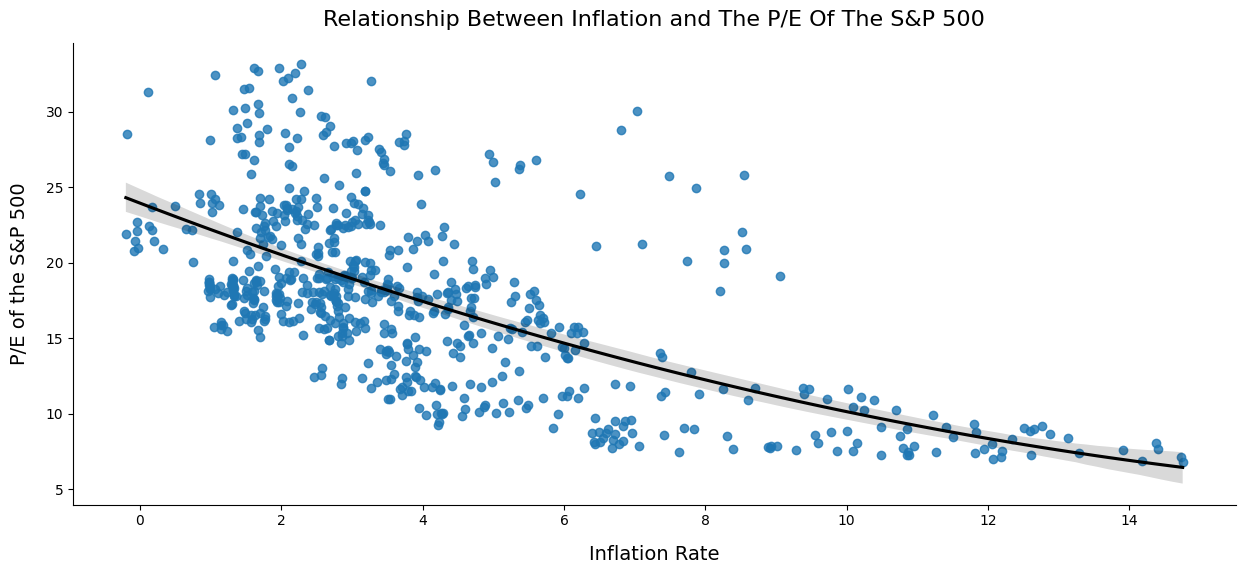

In [27]:
plt.figure(figsize=(15,6))
ax = sns.regplot(x='Inflation', y='S&P500_PE', data=df, order = 2, line_kws={"color":"black"})
sns.despine()
plt.xlabel("Inflation Rate", fontsize= 14, labelpad =12)
plt.ylabel("P/E of the S&P 500", fontsize= 14, labelpad =12)
plt.title("Relationship Between Inflation and The P/E Of The S&P 500", fontsize=16, pad= 12);

In [12]:
X = df['Inflation']
y = df['S&P500_PE']

## Statsmodel Method

https://ostwalprasad.github.io/machine-learning/Polynomial-Regression-using-statsmodel.html

In [20]:
from sklearn.preprocessing import PolynomialFeatures
sm_poly = PolynomialFeatures(degree=2)
sm_poly_features = sm_poly.fit_transform(X.values.reshape(-1,1))

model = sm.OLS(y, sm_poly_features).fit()
ypred = model.predict(sm_poly_features) 

In [21]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              S&P500_PE   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     224.2
Date:                Mon, 06 Feb 2023   Prob (F-statistic):           1.60e-75
Time:                        11:40:10   Log-Likelihood:                -2006.2
No. Observations:                 684   AIC:                             4018.
Df Residuals:                     681   BIC:                             4032.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.9459      0.503     47.559      0.000      22.957      24.934
x1            -1.7917      0.206     -8.706      0.000      -2.196      -1.388
x2             0.0410      0.016      2.575      0.010       0.010       0.072
==============================================================================
Omnibus:                       77.693   Durbin-Watson:                   0.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.845
Skew:                           0.907   Prob(JB):                     7.67e-23
Kurtosis:                       3.530   Cond. No.                         137.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
model.params

const    23.292721
x1       -1.268845
x2       -0.060937
x3        0.005187
dtype: float64

In [16]:
model.conf_int()

,0,1
const,21.869117,24.716324
x1,-2.183231,-0.354458
x2,-0.223895,0.102021
x3,-0.002951,0.013325


In [17]:
model.conf_int()[0][0]

21.86911729430367

In [30]:
user_pred = 2.66

print(f"""The estimated PE value for the S&P 500 based on an inflation rate of {user_pred} is {round(model.params[0] + model.params[1]*user_pred + model.params[2]*user_pred,2)}""")

The estimated PE value for the S&P 500 based on an inflation rate of 2.66 is 19.29


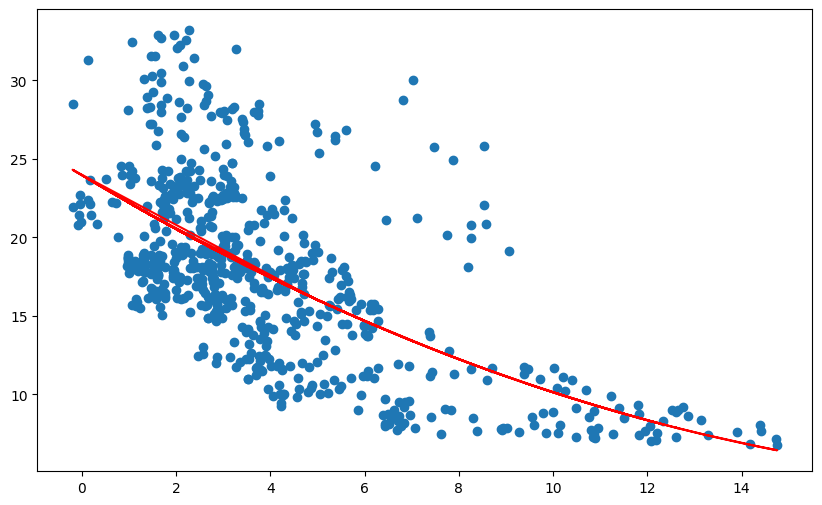

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(X, y)
plt.plot(X, ypred, c="red")
plt.show()